In [1]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

/Users/sakka/.pyenv/versions/anaconda3-4.2.0/lib/python3.5/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [104]:
dataset_df = pd.DataFrame()

day_lst = ["20170416", "20170417", "20170420", "20170421", "20170422", "20181030"]

for day in day_lst:
    for t_idx in range(9, 17):
        tmp_dataset_df = pd.read_csv("../../data/datasets/{0}/default/time_series_{1}.csv".format(day, t_idx))

        # check NaN count
        assert tmp_dataset_df.isnull().values.sum() == 0

        dataset_df = pd.concat([dataset_df, tmp_dataset_df])

    # shuffle dataset
    #dataset_df = dataset_df.sample(frac=1)
    dataset_df = dataset_df.fillna(0)
    
    # check NaN count
    assert dataset_df.isnull().values.sum() == 0
    
    break
    
dataset_df.head()    

,Fri,Mon,Sat,Sun,Thurs,Tue,Wed,area_ratio,degree_mean,degree_mean_shift1,...,overall_dir_left_up,overall_dir_right,overall_dir_right_down,overall_dir_right_up,right,right_down,right_up,up,var,var_shift1
0,0,0,0,1,0,0,0,0.000060,126.488372,-30.693446,...,0,1,0,0,0.325581,0.069767,0.116279,0.000000,22.5958,21.1866
1,0,0,0,1,0,0,0,0.000060,127.688889,1.200517,...,0,1,0,0,0.311111,0.133333,0.111111,0.000000,26.3131,3.7173
2,0,0,0,1,0,0,0,0.000045,142.135135,14.446246,...,0,1,0,0,0.378378,0.108108,0.216216,0.027027,27.2595,0.9464
3,0,0,0,1,0,0,0,0.000091,151.263158,9.128023,...,0,1,0,0,0.315789,0.078947,0.184211,0.000000,26.6687,-0.5908
4,0,0,0,1,0,0,0,0.000106,114.333333,-36.929825,...,0,1,0,0,0.266667,0.200000,0.066667,0.000000,33.2341,6.5654


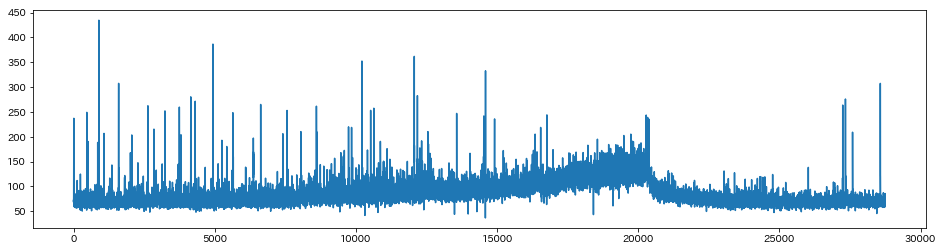

In [105]:
plt.figure(figsize=(16, 4))
plt.plot(list(dataset_df["max"]))

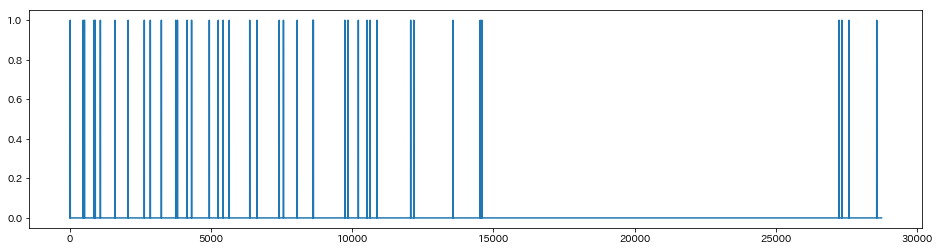

In [106]:
plt.figure(figsize=(16, 4))
plt.plot(list(dataset_df["label"]))

# label 作成

Class Label (5分前くらいには知りたい)  
5:  加速が発生  
4:  30秒前 (30 frame)   
3:  5分前  (300 frame)  
2: 10分前  (600 frame)   
1: その他 ()   

In [107]:
label_arr = np.array(dataset_df["label"])
label_arr[label_arr == 1] = 5
label_arr[label_arr == 0] = 1


label_arr[:5]

array([1, 1, 1, 1, 1])

In [108]:
flag_idx = np.where(label_arr == 5)[0]
print(flag_idx)

width2label = {600:2, 300:3, 30:4}

for width, label in width2label.items():
    for end_idx in flag_idx:
        start_idx = max(0, end_idx - width)
        label_arr[start_idx:end_idx] = label
        
label_arr[flag_idx] = 5
label_arr[:5]

[    8    10    11   470   471   515   856   896   897   898  1079  1598
  2063  2634  2635  2848  3237  3238  3239  3747  3749  3806  3809  4151
  4152  4309  4937  5254  5427  5643  6368  6628  7414  7561  7562  7563
  8051  8602  8622  9740  9847 10213 10214 10215 10523 10635 10867 10869
 12067 12068 12069 12179 13569 14530 14591 14592 27242 27338 27339 27590
 28573 28575]


array([4, 4, 4, 4, 4])

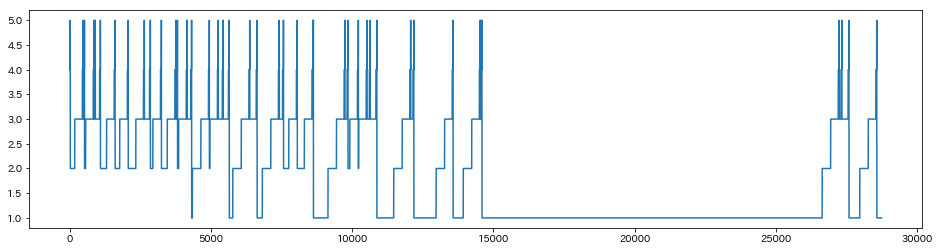

In [109]:
plt.figure(figsize=(16, 4))
plt.plot(label_arr)

In [110]:
np.where(label_arr == 5)

(array([    8,    10,    11,   470,   471,   515,   856,   896,   897,
          898,  1079,  1598,  2063,  2634,  2635,  2848,  3237,  3238,
         3239,  3747,  3749,  3806,  3809,  4151,  4152,  4309,  4937,
         5254,  5427,  5643,  6368,  6628,  7414,  7561,  7562,  7563,
         8051,  8602,  8622,  9740,  9847, 10213, 10214, 10215, 10523,
        10635, 10867, 10869, 12067, 12068, 12069, 12179, 13569, 14530,
        14591, 14592, 27242, 27338, 27339, 27590, 28573, 28575]),)

In [111]:
def make_label(label_df):
    """
    5: acceralation
    4: after 30 sec (30 frame)
    3: after 5 min (300 frame)
    2: after 10 min (600 frame)
    1: other
    """
    label_arr  = np.array(label_df)
    label_arr[label_arr == 1] = 5
    label_arr[label_arr == 0] = 1
    flag_idx = np.where(label_arr == 5)[0]

    width2label = {600:2, 300:3, 30:4}

    for width, label in width2label.items():
        for end_idx in flag_idx:
            start_idx = max(0, end_idx - width)
            label_arr[start_idx:end_idx] = label

    label_arr[flag_idx] = 5
    return label_arr

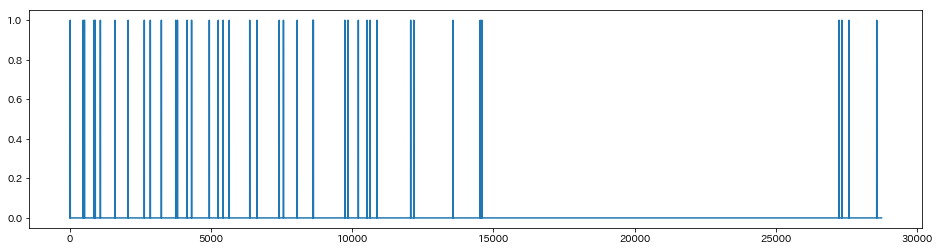

In [113]:
plt.figure(figsize=(16, 4))
plt.plot(list(dataset_df["label"]))

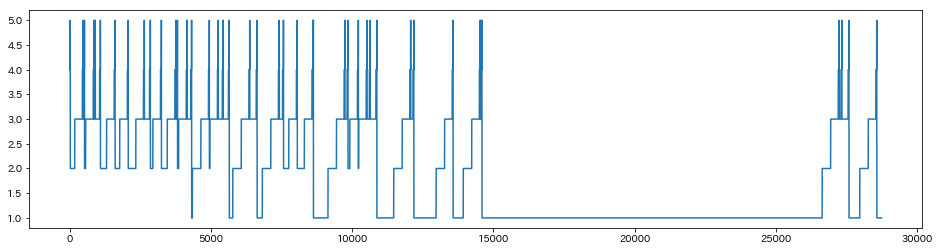

In [103]:
plt.figure(figsize=(16, 4))
plt.plot(make_label(dataset_df["label"]))